# Искуственные нейронные сети

В данной лекции мы рассмотрим как применяется математический аппарат искусственный нейронных сетей (artifical neural networks) в задаче распознавания рукописных цифр [MNIST](http://yann.lecun.com/exdb/mnist/).

Для работы с нейронными сетями будем использовать библиотеку [keras](https://keras.io/).

Начнем с загрузки набора данных и его описания.

In [1]:
from keras.datasets import mnist

train, test = mnist.load_data()
X_train, y_train = train
X_test, y_test = test
n = X_train.shape[0]
m = X_train.shape[1]*X_train.shape[2]
nclasses = 10

Using TensorFlow backend.


Каждая цифра представляет собой черно белое изображение с разрешением 28x28. Вектор признаков, таким образом, имеет размерность $28 \cdot 28= 784$. Каждый признак представляет собой интенсивность конкретного пикселя.

Целевая переменная принимает одно из 10 значений $0, 1, \dots, 9$.

Визуализируем несколько случайных примеров из обучающей выборки.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


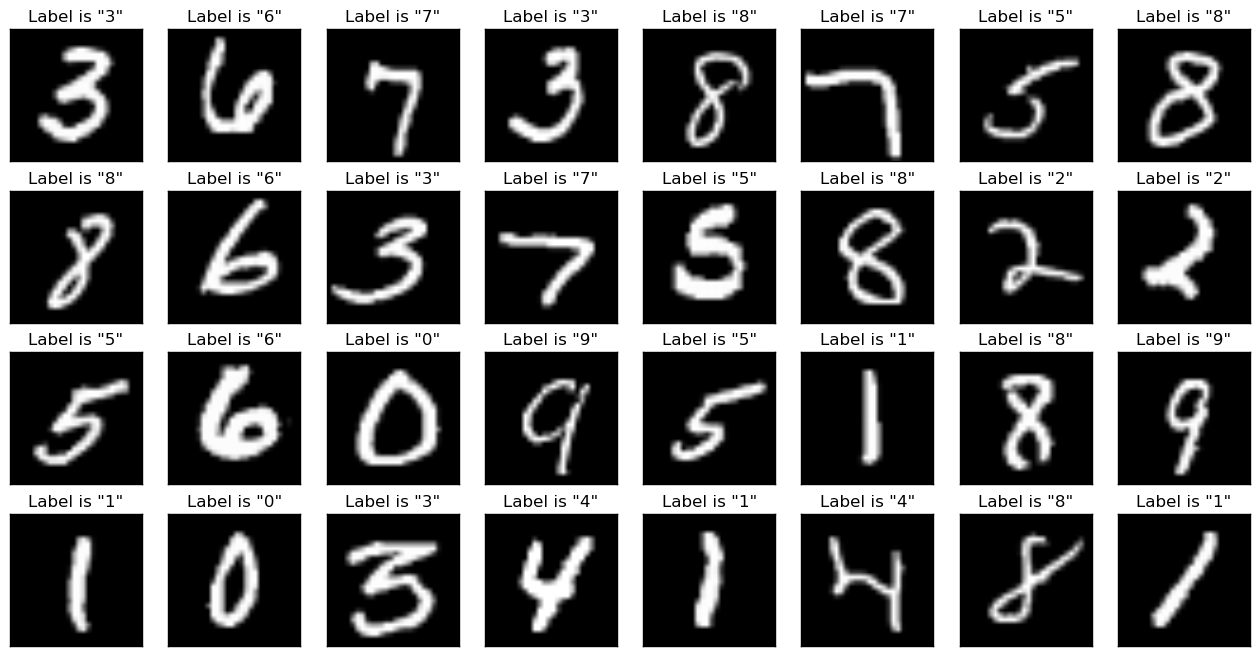

In [2]:
%pylab inline

nrows = 4
ncols = 8
_, ax = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
for k, nsample in enumerate(np.random.randint(low=0, high=n, size=nrows*ncols)):
    i = k // ncols
    j = k % ncols
    ax[i, j].imshow(X_train[nsample], cmap='gray')
    ax[i, j].set_title('Label is "{}"'.format(y_train[nsample]))
    ax[i, j].xaxis.set_visible(False)
    ax[i, j].yaxis.set_visible(False)

## Искуственный нейрон

![alt text](fig/neuron.png "Модель искусственного нейрона")

Таким образом видно, что искуственный нейрон реализует отображение вида
$$
    h_w(x) = \varphi(w_0 + \sum\limits_{i=1}^{m} w_i x_i)
$$

В случае, если активационная функция $\varphi$ предсталвяет собой сигмоиду, то мы получаем модель Логистической регрессии.



## Алгоритм обратного распространения ошибки

По аналогии с методом градиентного спуска для обучения модели логистической регресси, для для обучения модели искуственного нейрона используется алгоритм обратного распростарнения ошибки.

![](fig/single-backprop.png)

Обозначим функцию вычисления ошибки (аналог функции потерь) как $E$. Тогда для вычисления вклада каждого веса $w_i$ в величину ошибки нам необходимо вычислить частные производные, используя правило вычисления производной для сложной функции
$$
\frac{\partial E}{\partial w_i} = \frac{d E}{d o}\frac{d\varphi}{dz}\frac{\partial z}{\partial w_i}.
$$

Последняя производная может быть легко представлена в виде
$$
\delta_i = \frac{\partial z}{\partial w_i} = \frac{\partial}{\partial w_i}\left(\sum\limits_{i=o}^{m}x_iw_i\right) = x_i.
$$

В случае, если сигмоида используется в качестве функции активации $\varphi(z) = (1 + e^{-z})^{-1}$, то ее производную можно представить следующим образом
$$
\frac{d \varphi}{dz} = \varphi(z)(1 - \varphi(z)).
$$

И если рассмотреть в качестве функции вычисления ошибки половину квадрата ошибки $E = \frac{1}{2}(\hat o - o)^2$, то мы получим выражение для величины вклада каждого из весов $w_i$ в ошибку $e$
$$
\delta_i = (\hat o - o)\varphi'(z)x_i.
$$

Далее мы можем использовать данные значения для обновления весов нейрона.
$$
\hat w_i = w_i - \alpha \delta_i.
$$
Здесь $\alpha$ - скорость обучения.

## Нейронная сеть

Одной из важнейших особенностей использования математической модели искуственного нейрона является возможность объединять их в нейронные сети. 

![](fig/2layers.png)

На рисунке предтавленна нейорнная сеть из двух слоев, один из которых называется входным, а другой - выходным.

In [3]:
from sklearn.preprocessing import OneHotEncoder

target_encoder = OneHotEncoder(n_values=nclasses, sparse=False)

y_train_enc = target_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_enc = target_encoder.transform(y_test.reshape(-1, 1))

In [8]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(m, ),
                     name="Input"))
model.add(Dense(units=nclasses,
                activation='softmax',
                name="Output"))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


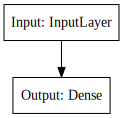

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
train_history = model.fit(X_train.reshape(-1, m), y_train_enc,
                          validation_data=(X_test.reshape(-1, m), y_test_enc),
                          shuffle=True,
                          epochs=100,
                          batch_size=32
                          )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 2.3077 - acc: 0.8552 - val_loss: 2.1752 - val_acc: 0.8636

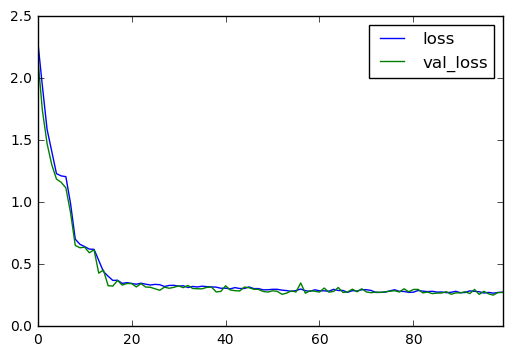

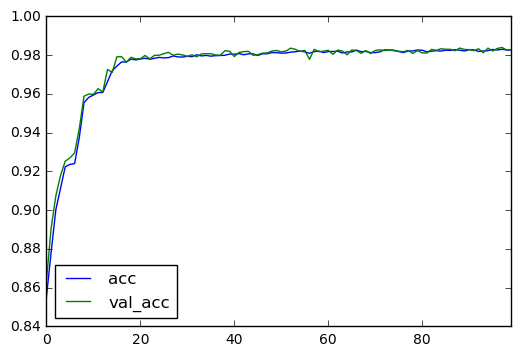

In [12]:
import pandas as pd

history = pd.DataFrame(data=train_history.history)
history[['loss', 'val_loss']].plot()
history[['acc', 'val_acc']].plot()